In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.io import loadmat
from scipy import stats

%matplotlib inline

# Anomaly Detection and Recommender Systems

## Anomaly detection

In this exercise, you will implement an anomaly detection algorithm to detect
anomalous behavior in server computers. The features measure the through-
put (mb/s) and latency (ms) of response of each server. While your servers
were operating, you collected m = 307 examples of how they were behaving, and thus have an unlabeled dataset $\{x^{(1)}, \dots, x^{(m)}\}$g. 

You suspect that the vast majority of these examples are "normal" (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.

You will use a Gaussian model to detect anomalous examples in your
dataset. You will first start on a 2D dataset that will allow you to visualize
what the algorithm is doing. On that dataset you will fit a Gaussian dis-
tribution and then find values that have very low probability and hence can
be considered anomalies.

In [2]:
data = loadmat('data/ex8data1.mat')

In [3]:
X = data['X']

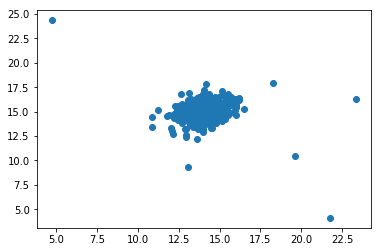

In [4]:
plt.scatter(X[:,0], X[:,1]);

### Estimating parameters for a Gaussian

You can estimate the parameters, $(\mu_i, \sigma_i^2)$, of the i-th feature by using the following equations. To estimate the mean, you will use:

$$\mu_i = \frac{1}{m}\sum_{j=1}^m(x_i^{(j)})$$

and for the variance you will use:

$$\sigma_i^2 = \frac{1}{m}\sum_{j=1}^m(x_i^{(j)}-\mu_i)^2$$

Your task is to complete the code in `estimateGaussian.m`. This function
takes as input the data matrix X and should output an n-dimension vector
mu that holds the mean of all the n features and another n-dimension vector
sigma2 that holds the variances of all the features. You can implement this
using a for-loop over every feature and every training example (though a vec-
torized implementation might be more eficient; feel free to use a vectorized
implementation if you prefer).

In [5]:
def estimate_gaussian(X):
    mu = X.mean(axis=0)
    sigma = X.var(axis=0)
    
    return mu, sigma

### Selecting the threshold $\epsilon$

Now that you have estimated the Gaussian parameters, you can investigate
which examples have a very high probability given this distribution and which
examples have a very low probability.

The function `selectThreshold.m` should return two values; the first is
the selected threshold ". If an example x has a low probability p(x) < ",
then it is considered to be an anomaly. The function should also return the
F1 score, which tells you how well you're doing on finding the ground truth
anomalies given a certain threshold. For many different values of ", you will
compute the resulting F1 score by computing how many examples the current
threshold classiffes correctly and incorrectly.

The F1 score is computed using precision (prec) and recall (rec):

$$F_1 = \frac{2\cdot\text{prec}\cdot\text{rec}}{\text{prec} +\text{rec}}$$

You compute precision and recall by:

$$ \text{prec} = \frac{tp}{tp+fp}$$
$$ \text{rec} = \frac{tp}{tp+fn'}$$

where
+ $tp$ is the number of true positives: the ground truth label says it's an anomaly and our algorithm correctly classified it as an anomaly.

+ $fp$ is the number of false positives: the ground truth label says it's not an anomaly, but our algorithm incorrectly classified it as an anomaly.

+ $fn$ is the number of false negatives: the ground truth label says it's an anomaly, but our algorithm incorrectly classified it as not being anomalous.

In [6]:
def select_threshold(prob, y):
    
    best_epsilon = 0
    best_F1 = 0
    F1 = 0
    
    step = (prob.max() - prob.min()) / 1000
    
    for epsilon in np.arange(prob.min(), prob.max(), step):
        preds = prob < epsilon
        
        tp = np.sum(np.logical_and(preds == 1, y == 1)).astype(float)
        fp = np.sum(np.logical_and(preds == 1, y == 0)).astype(float)
        fn = np.sum(np.logical_and(preds == 0, y == 1)).astype(float)
        
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        F1 = (2 * prec * rec) / (prec + rec)
        
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
    
    return best_epsilon, best_F1

In [7]:
Xval = data['Xval'] #validated data
yval = data['yval'] #validated data

In [8]:
mu, sigma = estimate_gaussian(X)

In [9]:
p = np.zeros((Xval.shape[0], Xval.shape[1]))
p[:,0] = stats.norm(mu[0], sigma[0]).pdf(Xval[:,0])
p[:,1] = stats.norm(mu[1], sigma[1]).pdf(Xval[:,1])

In [10]:
epsilon, f1 = select_threshold(p, yval)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in double_scalars


In [11]:
epsilon

0.009566706005956842

In [12]:
p = np.zeros((X.shape[0], X.shape[1]))
p[:,0] = stats.norm(mu[0], sigma[0]).pdf(X[:,0])
p[:,1] = stats.norm(mu[1], sigma[1]).pdf(X[:,1])

In [13]:
outliers = np.where(p < epsilon)

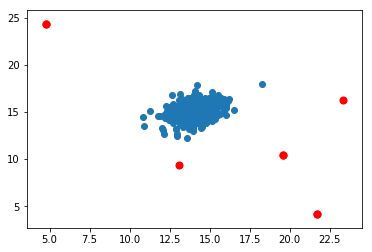

In [14]:
plt.scatter(X[:,0], X[:,1])
plt.scatter(X[outliers[0],0], X[outliers[0],1], s=50, color='r', marker='o');

Those look pretty good, though there is one stray blue dot, that seems pretty similar in distance away as the closest red one...I'm also getting a numpy error in `select_threshold`, I think has to do with the logical, so I'll try and clean that up soon.

## Recommender Systems

In this part of the exercise, you will implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings.

In [15]:
data = loadmat('data/ex8_movies.mat')

The matrix $Y$ (a num movies X num users matrix) stores the ratings $y^{(i,j)}$ (from 1 to 5). The matrix $R$ is an binary-valued indicator matrix, where $R(i, j) = 1$ if user $j$ gave a rating to movie $i$, and $R(i, j) = 0$ otherwise. 

The objective of collaborative filtering is to predict movie ratings for the movies that users have not yet rated, that is, the entries with $R(i, j) = 0$. This will allow us to recommend the movies with the highest predicted ratings to the user.

In [16]:
Y = data['Y']
R = data['R']

## Collaborative filtering learning algorithm and cost function

In [17]:
def cost(params, Y, R, num_features):
    Y = np.matrix(Y)  
    R = np.matrix(R)
    
    num_movies = Y.shape[0]
    num_users = Y.shape[1]
    
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))
    theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))
    
    J = 0
    
    err = np.multiply((X.dot(theta.T)) - Y, R)
    
    J = (1 / 2.0) * np.sum(np.power(err,2))
    
    return J

Let's load the test data provided, and see if we want match the expected output of 22.22.

In [18]:
params_test = loadmat('data/ex8_movieParams.mat')
X_test = params_test['X']
theta_test = params_test['Theta']

In [19]:
users = 4
movies = 5
features = 3

X_sub = X_test[:movies, :features]
theta_sub = theta_test[:users, :features]

Y_sub = Y[:movies, :users]
R_sub = R[:movies, :users]

params = np.concatenate((np.ravel(X_sub), np.ravel(theta_sub)))

In [20]:
cost(params, Y_sub, R_sub, features) #great

22.224603725685675

### Collaborative filtering gradient

In [21]:
def gradient(err, X, theta):
    X_grad = err.dot(theta)
    theta_grad = err.T.dot(X)
    
    grad = np.concatenate((np.ravel(X_grad), np.ravel(theta_grad)))
    return grad

Now we need to edit our cost function to return the X and $\theta$ gradients.

In [22]:
def cost(params, Y, R, num_features):
    Y = np.matrix(Y)  
    R = np.matrix(R)
    
    num_movies = Y.shape[0]
    num_users = Y.shape[1]
    
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))
    theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))
    
    J = 0
    
    err = np.multiply((X.dot(theta.T)) - Y, R)
    
    grad = gradient(err, X, theta)
    J = (1 / 2.0) * np.sum(np.power(err,2))
    
    return J, grad

In [23]:
#quick test
J, grad = cost(params, Y_sub, R_sub, features)

In [24]:
J, grad

(22.224603725685675,
 array([ -2.52899165,   7.57570308,  -1.89979026,  -0.56819597,
          3.35265031,  -0.52339845,  -0.83240713,   4.91163297,
         -0.76677878,  -0.38358278,   2.26333698,  -0.35334048,
         -0.80378006,   4.74271842,  -0.74040871, -10.5680202 ,
          4.62776019,  -7.16004443,  -3.05099006,   1.16441367,
         -3.47410789,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ]))

## Regularized cost function

You should now add regularization to your original computations of the cost function, J.

In [25]:
def cost_reg(params, Y, R, num_features, lam):
    Y = np.matrix(Y)  
    R = np.matrix(R)
    
    num_movies = Y.shape[0]
    num_users = Y.shape[1]
    
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))
    theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))
    
    J = 0
    
    err = np.multiply((X.dot(theta.T)) - Y, R)
    
    grad = gradient_reg(err, X, theta, lam)
    
    J = (1 / 2.0) * np.sum(np.power(err,2))
    
    J += ((lam / 2) * np.sum(np.power(theta, 2))) + ((lam / 2) * np.sum(np.power(X, 2)))
    
    return J, grad

### Regularized gradient

In [26]:
def gradient_reg(err, X, theta, lam):
    X_grad = err.dot(theta) + (lam * X)
    theta_grad = err.T.dot(X) + (lam * theta)
    
    grad = np.concatenate((np.ravel(X_grad), np.ravel(theta_grad)))
    return grad

In [27]:
J, grad = cost_reg(params, Y_sub, R_sub, features, lam = 1.5)

In [28]:
J, grad

(31.34405624427422,
 array([ -0.95596339,   6.97535514,  -0.10861109,   0.60308088,
          2.77421145,   0.25839822,   0.12985616,   4.0898522 ,
         -0.89247334,   0.29684395,   1.06300933,   0.66738144,
          0.60252677,   4.90185327,  -0.19747928, -10.13985478,
          2.10136256,  -6.76563628,  -2.29347024,   0.48244098,
         -2.99791422,  -0.64787484,  -0.71820673,   1.27006666,
          1.09289758,  -0.40784086,   0.49026541]))

### Learning movie recommendations

After you have finished implementing the collaborative filtering cost function and gradient, you can now start training your algorithm to make movie recommendations for yourself.

The exercise provides some rating, so we'll use those;

In [29]:
ratings = np.zeros((1682, 1))

ratings[0] = 4
ratings[6] = 3
ratings[11] = 5
ratings[53] = 4
ratings[63] = 5
ratings[65] = 3
ratings[68] = 5
ratings[97] = 2
ratings[182] = 4
ratings[225] = 5
ratings[354] = 5

Add our ratings to the dataset;

In [30]:
Y = np.append(Y, ratings, axis=1)
R = np.append(R, ratings != 0, axis=1)

In [31]:
movies = Y.shape[0] 
users = Y.shape[1] 
features = 10
learning_rate = 1.5

In [32]:
X_train = np.random.random(size=(movies, features))
init_theta = np.random.random(size=(users, features))
params = np.concatenate((np.ravel(X_train), np.ravel(init_theta)))

Accidentally did this without normalization the first time, all rating were about 4.5...

In [33]:
Y_mu = np.zeros((movies, 1))
Y_norm = np.zeros((movies, users))

for i in range(movies):
    idx = np.where(R[i,:] == 1)[0]
    Y_mu[i] = Y[i,idx].mean()
    Y_norm[i,idx] = Y[i,idx] - Y_mu[i]

In [34]:
from scipy.optimize import minimize

fmin = minimize(fun=cost_reg, x0=params, args=(Y, R, features, learning_rate), 
                method='CG', jac=True, options={'maxiter': 100})

In [35]:
X = np.matrix(np.reshape(fmin.x[:movies * features], (movies, features)))
theta = np.matrix(np.reshape(fmin.x[movies * features:], (users, features)))

In [36]:
pred = X.dot(theta.T)
my_preds = pred[:, -1] + Y_mu

In [37]:
idx = np.argsort(my_preds, axis=0)[::-1]

In [38]:
movies_df = pd.read_csv('data/movie_ids.txt', sep='|', header=None, encoding='latin-1')

In [39]:
print("Top 10 movie predictions:")
for i in range(10):
    j = int(idx[i])
    print('Predicted rating of {0} for {1}.'.format(str(float(my_preds[j])), movies_df.iloc[j].values[0][3:]))

Top 10 movie predictions:
Predicted rating of 9.559327874522403 for  Titanic (1997).
Predicted rating of 9.353088496608489 for Star Wars (1977).
Predicted rating of 9.280475652234484 for  Raiders of the Lost Ark (1981).
Predicted rating of 9.128090054420543 for  Empire Strikes Back, The (1980).
Predicted rating of 9.062801057380007 for  Return of the Jedi (1983).
Predicted rating of 8.972275604471335 for Shawshank Redemption, The (1994).
Predicted rating of 8.775718079576299 for  Wrong Trousers, The (1993).
Predicted rating of 8.760104504332915 for Terminator 2: Judgment Day (1991).
Predicted rating of 8.578818016493017 for Braveheart (1995).
Predicted rating of 8.523390237103122 for  Indiana Jones and the Last Crusade (1989).


The ratings are pretty close to what's provided in the exercise!